In [19]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
current_path = '/Users/himanshuaggarwal/ironhack-my-content/himanshu/classModules/module3/jigsaw-toxic-comment-classification-challenge'
os.chdir(current_path)
print(os.listdir())

['.DS_Store', 'test_labels.csv', 'test.csv', 'train.csv', 'sample_submission.csv']


In [22]:
data_path = current_path + '/train.csv'
data = pd.read_csv(data_path)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [23]:
data.shape

(159571, 8)

In [24]:
data['toxic'].value_counts()

0    144277
1     15294
Name: toxic, dtype: int64

In [25]:
data['severe_toxic'].value_counts()

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [26]:
data['obscene'].value_counts()

0    151122
1      8449
Name: obscene, dtype: int64

In [27]:
data['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

In [28]:
data['insult'].value_counts()

0    151694
1      7877
Name: insult, dtype: int64

In [29]:
data['identity_hate'].value_counts()

0    158166
1      1405
Name: identity_hate, dtype: int64

In [30]:
dataFiltered = data.copy()
dataFiltered['dummySum']= data['identity_hate']+data['insult']+data['threat']+data['obscene']+data['severe_toxic']+data['toxic']
dataFiltered = dataFiltered[dataFiltered['dummySum']>0]
dataFiltered = dataFiltered.drop(['dummySum'], axis=1).reset_index().drop(['index'], axis=1)
dataFiltered.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
1,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
2,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [31]:
dataFiltered.shape

(16225, 8)

In [34]:
data = data.sample(frac=0.3)

In [35]:
data.shape

(28723, 8)

In [37]:
data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = list(map(lambda x: re.sub('[?|!|\'|"|#|,|.]','',x),data['comment_text']))
data['comment_text'] = list(map(lambda x: x.strip(),data['comment_text']))
data['comment_text'] = list(map(lambda x: x.replace('\n',' '),data['comment_text']))
# data['comment_text'] = list(map(lambda x: " ".join(re.findall('\w+',x)),data['comment_text']))
# data = data.drop(['id'], axis=1)
data.head()                             

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
137571,e027d1e7c3589a57,make that four fifth is underway this is redi...,1,0,0,0,0,0
83749,e0220e8860e8067d,actually it appears that you were dumbfoundeds...,0,0,0,0,0,0
57942,9b2b43979295d8f6,added in the parts where andrew cuomo said the...,0,0,0,0,0,0
86564,e789d1396ff4e0b0,category:unassessed american old west articles...,0,0,0,0,0,0
26238,456c7eb0612dd7c3,it only needs one word: mainly we say they mai...,0,0,0,0,0,0


### Stop words removal

In [38]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
# stop_words

In [40]:
def cleanStopWords(x, sw=stop_words):
    x_new = []
    for item in x.split():
        if item not in sw:
            x_new.append(item)
    return (' '.join(x_new))

In [41]:
data['comment_text'] = list(map(cleanStopWords,data['comment_text']))

In [42]:
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
137571,e027d1e7c3589a57,make fifth underway rediculous 18:32 29 dec 20...,1,0,0,0,0,0
83749,e0220e8860e8067d,actually appears dumbfoundedso decided (all ) ...,0,0,0,0,0,0
57942,9b2b43979295d8f6,added parts andrew cuomo said investigation ca...,0,0,0,0,0,0
86564,e789d1396ff4e0b0,category:unassessed american old west articles...,0,0,0,0,0,0
26238,456c7eb0612dd7c3,needs word: mainly say mainly live occyupied k...,0,0,0,0,0,0


### Stemming

In [43]:
stemmer = SnowballStemmer("english")
def cleanStemming(x):
    stemSentence = []
    for word in x.split():
        stem = stemmer.stem(word)
        stemSentence.append(stem)
    return ((' '.join(stemSentence)).strip())
data['comment_text'] = data['comment_text'].apply(cleanStemming)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
137571,e027d1e7c3589a57,make fifth underway redicul 18:32 29 dec 2004 ...,1,0,0,0,0,0
83749,e0220e8860e8067d,actual appear dumbfoundedso decid (all ) lash ...,0,0,0,0,0,0
57942,9b2b43979295d8f6,ad part andrew cuomo said investig came succes...,0,0,0,0,0,0
86564,e789d1396ff4e0b0,category:unassess american old west articl bac...,0,0,0,0,0,0
26238,456c7eb0612dd7c3,need word: main say main live occyupi kurdista...,0,0,0,0,0,0


In [44]:
data = data.drop(['id'], axis=1)

### TD-IDF

In [45]:
X = data['comment_text']
y = data.drop(['comment_text'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=0.2, shuffle=True)

In [46]:
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(X_train)
# Fit method makes the model learn vocabulary and idf from the data 
X_train_vector = vectorizer.transform(X_train)
# Transform method transforms the documents to document-term matrix
# Please note that either you can fit and transform in two steps
# Or you can use the method fit_transform as shown below
# x_train = vectorizer.fit_transform(train)

In [25]:
X_train_vector

<76594x3597468 sparse matrix of type '<class 'numpy.float64'>'
	with 6984975 stored elements in Compressed Sparse Row format>

In [26]:
# vectorizer.get_params()
# vectorizer.get_feature_names()

In [27]:
X_test_vector = vectorizer.transform(X_test)

### n-grams

## One vs Rest Methodology

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [29]:
y_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
42505,0,0,0,0,0,0
148263,0,0,0,0,0,0
121293,0,0,0,0,0,0
79845,0,0,0,0,0,0
21001,0,0,0,0,0,0


In [30]:
categories = data.columns[2:]
logit = LogisticRegression(penalty='l2', multi_class='ovr')
for category in categories:
    logit.fit(X_train_vector, y_train[category])
    predictions = logit.predict(X_test_vector)
    print('For:', category)
    print("\n")
    print('Test accuracy is {}'.format(accuracy_score(y_test[category], predictions)))


For: severe_toxic


Test accuracy is 0.9898167006109979
For: obscene


Test accuracy is 0.975977857851585
For: threat


Test accuracy is 0.9970233432555224
For: insult


Test accuracy is 0.9718523160478354
For: identity_hate


Test accuracy is 0.9918533604887984


In [31]:
# pip install scikit-multilearn

## Adapted Algorithm

In [ ]:
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
classifier_new = MLkNN(k=10)
x_train = lil_matrix(X_train_vector).toarray()
y_train = lil_matrix(y_train).toarray()
x_test = lil_matrix(X_test_vector).toarray()

In [ ]:
classifier_new.fit(x_train, y_train)
predictions_new = classifier_new.predict(x_test)
print("Accuracy = ",accuracy_score(y_test,predictions_new))
print("\n")

# Word Cloud 

In [14]:
dataFiltered.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
1,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
2,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
3,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
4,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [17]:
pip install WordCloud

     |████████████████████████████████| 163kB 3.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [48]:
from wordcloud import WordCloud

In [ ]:
wordsCol = list(map())

In [55]:
words = []
for comments in data['comment_text']:
    temp = re.findall('\w{4,}', comments)
    for item in temp:
        words.append(item)

In [57]:
wordcloud = WordCloud(width = 800, height = 800, min_font_size = 10).generate(" ".join(words)) 

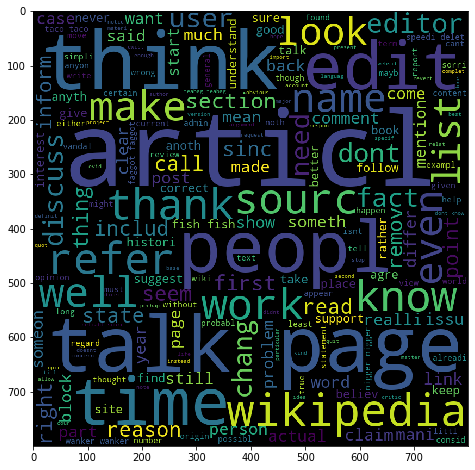

In [58]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud)
plt.show()